# Carregamento e preparação de *datasets*

O carregamento e preparação de *datasets* é um ótimo exercício para tomarmos conhecimento das ferramentas a serem utilizadas para o processamento de sinais em `python`, seja sinais biológicos quanto de outra natureza, como um som, corrente elétrica, etc.

Nesta `notebook` será apresentado o carregamento de um *dataset* público do *website* `UCI - Machine Learning Repository`. O *dataset* a ser utilizado é o `EEG Database Data Set` (https://archive.ics.uci.edu/ml/datasets/EEG+Database).


## Descrição do *dataset*:

A intenção deste *dataset* é examinar por meio de algoritmos de inteligência computacional a pré-disposição genética que um paciente possui ao alcoolismo.

Os principais dados analizados são do tipo *time-series*, em outras palavras, conjuntos de dados que representam um sinal mensurado no domínio do tempo. Os dados são completados com outros atributos como o nome do eletrodo, o número da amostra, etc. Outras informações relevantes do *dataset*:

- Quantidade de atributos: 4
- Número de instancias: 122
- Existem dados faltantes? Sim
- Tipos de dados encontrados: categórico, inteiro e real

Existem três categorias de dados neste *dataset*:

1. Small Data Set: Contem dados do experimento realizados para pessoas alcolicas e pessoas não alcolicas
2. Large Data Set: Contem dados dividos entre TREINO e TESTE para pessoas alcolicas e não alcolicas
3. Full Data Set: <font color='red'>**descrever**</font>

Cada sessão (*trial*) é armazenada da seguinte forma:

```
# co2a0000364.rd 
# 120 trials, 64 chans, 416 samples 368 post_stim samples 
# 3.906000 msecs uV 
# S1 obj , trial 0 
# FP1 chan 0 
0 FP1 0 -8.921 
0 FP1 1 -8.433 
0 FP1 2 -2.574 
0 FP1 3 5.239 
0 FP1 4 11.587 
0 FP1 5 14.028
...
```

As primeiras 4 linhas são de cabeçalho:

**linha 1**: identificação do paciente e se ele indica ser um alcoólatra (a) ou controle (c) pela quarta letra (co2**a**0000364);

**linha 4**: determina se o paciente foi exposto a um único estímulo (`S1 obj`), a dois estímulos iguais (`S2 match`) ou a dois estímulos diferentes (`S2 no match`);

**linha 5**: identifica o início da coleta dos dados pelo eletrodo FP1. As 4 colunas são:

```
número_da_sessão identificação_do_eletrodo número_da_amostra valor_em_micro_volts
```


## Implementação

### Imports

In [2]:
from urllib.request import urlopen, urlretrieve
import os
from subprocess import getoutput as gop
import glob # get all file paths
from re import search
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas

### Realizando o download 

Primeiro faremos um código para verificar se o *dataset* já foi baixado, caso contrário, executar o código de download:

In [3]:
urls = {
    'small': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/smni_eeg_data.tar.gz',
    'large_train': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TRAIN.tar.gz',
    'large_test': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TEST.tar.gz',
    'full': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/eeg_full.tar'
}

# verifica se o diretório dos datasets existe
if not os.path.exists('dataset/'):
    os.mkdir('dataset/')
    for k, v in urls.items():
        fn = v.split('/')[-1]
        print('Baixando:', fn, '...')
        urlretrieve(v, './dataset/{}'.format(fn))
    print('Downlod dos datasets concluído!')
else:
    print('Dataset já baixado!')

Dataset já baixado!


### Descompactando pastas e subpastas

Agora é necessário descompactar (recursivamente) diversas pastas e subpastas em arquivos GZip. Algumas pastas estão com o arquivo na extensão `.tar`, já outras, `.tar.gz`. Não obstante, algumas subpastas estão compactadas e outras não.

In [5]:
# único arquivo somente empacotado (tar)
try:
    os.mkdir('dataset/eeg_full/')
    gop('tar -xvf dataset/eeg_full.tar -C dataset/eeg_full')
    os.remove('dataset/eeg_full.tar')

    while glob.glob('dataset/**/*.gz', recursive=True):
        # quando o arquivo está empacotado (tar) e compactado (gz)
        for f in glob.iglob('dataset/**/*.tar.gz', recursive=True):
            gop('tar -zxvf {} -C {}'.format(f, f[:f.rindex('/')]))
            os.remove(f)
        # quando o arquivo está somente compactado (gz)
        for f in glob.iglob('dataset/**/*.gz', recursive=True):
            gop('gzip -d {}'.format(f))
    print('Descompactações finalizadas!')
except:
    print("Descompactação já realizada")

Descompactação já realizada


### Carregando parte do dataset

Vamos agora carregar o subconjunto "small" do *dataset* e fica como <font color='red'>**tarefa de casa**</font> carregar e preparar todos os outros subconjuntos...

In [9]:
# organizando melhor as pastas
try:
    os.rename('dataset/smni_eeg_data', 'dataset/small')
    os.rename('dataset/eeg_full', 'dataset/full')
    os.rename('dataset/SMNI_CMI_TRAIN/', 'dataset/large_train/')
    os.rename('dataset/SMNI_CMI_TEST/', 'dataset/large_test/')
except:
    print("organização já realizada")
finally:
    print(gop('ls -l dataset/'))

total 16
drwxrwxr-x 124 neos neos 4096 Abr 15 22:32 full
drwxr-xr-x  22 neos neos 4096 Out  5  1997 large_test
drwxr-xr-x  22 neos neos 4096 Out  5  1997 large_train
drwxr-xr-x   8 neos neos 4096 Abr 15 22:32 small


### Função generica para realizar o carregamento de um dataset

In [4]:
def load_data(folder_path):
    # 1ª dimensão dos dados contendo os sujeitos. Ex.: C_1, a_m, etc
    subjects = list()

    # get all dirs inside small folder
    folder = gop('ls {}'.format(folder_path)).split('\n')
    # for all dir insider folder
    for types in folder:
        if (not os.path.isdir('{}/{}'.format(folder_path, types))):
            continue
        files = gop('ls {}/{}'.format(folder_path, types)).split('\n')
        # 2ª dimensão dos dados contendo as sessões (trials)
        trials = list()

        # for all file in files
        for f in files:
            arquivo = open('{}/{}/{}'.format(folder_path, types, f))
            text = arquivo.readlines()
            # 3ª dimensão dos dados contendo os canais (eletrodos)
            chs = list()
            # 4ª dimensão dos dados contendo os valores em milivolts
            values = list()
            # for each line inside a file
            for line in text:
                # ex: "# FP1 chan 0"
                # look if this line is a new eletrodo info
                t = search('\w{1,3} chan \d{1,2}', line)
                # ex: "0 FP1 0 -8.921"
                # or if is a data line
                p = search('^\d{1,3}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)

                # if has a eeg data
                if p:
                    values.append(float(p.group('value')))
                # mudou para outro eletrodo
                elif t and values:
                    # append all values to this eletrodo
                    chs.append(values)
                    # reset values
                    values = list()
            # end for line
            # append last channel
            chs.append(values)

            # append all channels to one trial
            trials.append(chs)
            arquivo.close()
        # append all trials to one subject
        subjects.append(trials)
    return subjects

### Função para salvar um dataset em um formato mais conhecido

In [11]:
def gen_csv(trial):
    csv_data = []
    for channels in trial:
        csv_data.append([])
        for value in channels:
            csv_data[-1].append(value)
    
    return pandas.DataFrame.from_records(csv_data).T.to_csv(index=False, header=False)

### Identificando pastas relevantes

In [5]:
# identificando pastas
folders = {
    'small': 'dataset/small',
    'large_train': 'dataset/large_train',
    'large_test': 'dataset/large_test',
    'full': 'dataset/full',
}
# ------------ carregando pasta "small" ------------------

## Small Dataset

In [6]:
subjects = load_data(folders["small"])

data = np.array(subjects)
print(data.shape)

(6, 10, 64, 256)


### Dados carregados...

Os dados "single" foram dividos da seguinte forma:
```
[experimentos, triagens, canais, amostras]
```
formando um `numpy.array` de quatro dimensões.

Em seguida, vamos plotar esses dados para "tentar" visualizar algum padrão.

### Comparando dois Trials

Nesta etapa foi comparado duas triagens, sendo uma referente a um individuo alcolotra e outro um individo de controle

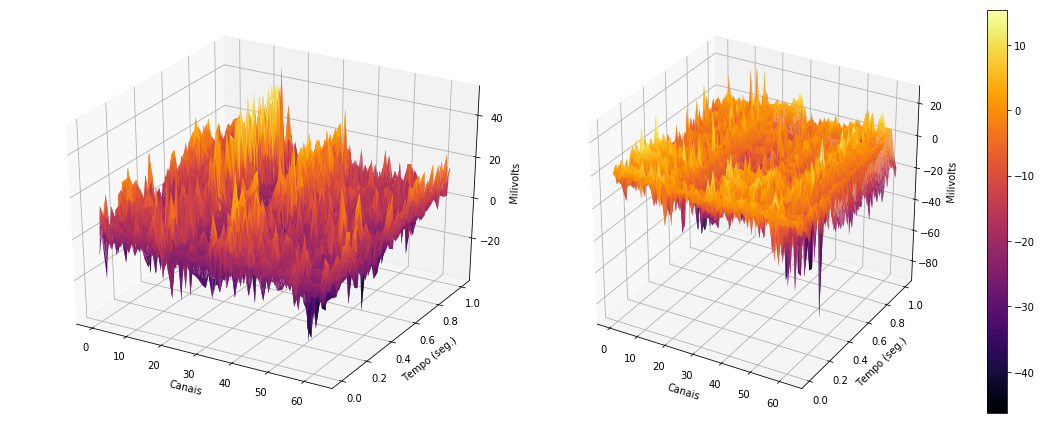

In [41]:
d1 = list()
d2 = list()

for e in range(64):
    for i, t in enumerate(np.linspace(0, 1, 256)):
        d1.append([e, t, data[0][0][e][i]])
        d2.append([e, t, data[1][0][e][i]])
d1 = np.array(d1)
d2 = np.array(d2)
x1, y1, z1 = d1[:,0], d1[:,1], d1[:,2]
x2, y2, z2 = d2[:,0], d2[:,1], d2[:,2]

plots = list()

plots.append([x1, y1, z1])
plots.append([x2, y2, z2])

fig = plt.figure(figsize=[15,6])

for i,j in zip(plots,range(1,len(plots)+1)):
    ax = fig.add_subplot(1, 2, j, projection='3d')
    surf = ax.plot_trisurf(i[0], i[1], i[2], cmap=cm.inferno, linewidth=1)
    ax.set_xlabel('Canais')
    ax.set_ylabel('Tempo (seg.)')
    ax.set_zlabel('Milivolts')

fig.colorbar(surf)
fig.tight_layout()
plt.show()

### Comparando a média de todos os Trial

Nesta proxima etapa, foi plotado a média de todos os trials de um experimento de uma pessoa alcotra comparado com um individuo de controle

(16384, 3)


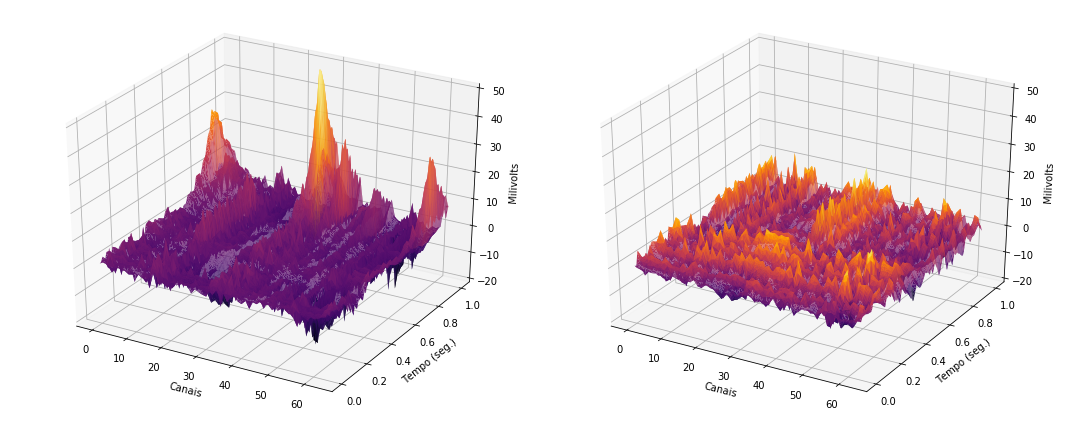

In [42]:
d1 = list()
d2 = list()

for e in range(64):
    dm0 = np.average(data[0], axis=0)
    dm1 = np.average(data[3], axis=0)

    for i, t in enumerate(np.linspace(0, 1, 256)):
        d1.append([e, t, dm0[e][i]])
        d2.append([e, t, dm1[e][i]])
d1 = np.array(d1)
print(d1.shape)
d2 = np.array(d2)
x1, y1, z1 = d1[:,0], d1[:,1], d1[:,2]
x2, y2, z2 = d2[:,0], d2[:,1], d2[:,2]

plots = list()

plots.append([x1, y1, z1])
plots.append([x2, y2, z2])

fig = plt.figure(figsize=[15,6])

for i,j in zip(plots,range(1,len(plots)+1)):
    ax = fig.add_subplot(1, 2, j, projection='3d')
    surf = ax.plot_trisurf(i[0], i[1], i[2], cmap=cm.inferno, linewidth=1)
    ax.set_zlim([-20, 50])
    ax.set_xlabel('Canais')
    ax.set_ylabel('Tempo (seg.)')
    ax.set_zlabel('Milivolts')
    
# fig.colorbar(surf)
fig.tight_layout()
plt.show()

### Salvar small dataset para csv

In [62]:
if not os.path.exists('dataset/small_csv/'):
    subjects_folders = ["a1co2a", "amco2a", "anco2a", "c1co2c", "cmco2c", "cnco2c"]
    folder_idx = 0

    for subject in data:
        new_folder = "dataset/small_csv/{}".format(subjects_folders[folder_idx])
        os.makedirs(new_folder)
        for idx, trial in enumerate(subject):
            f = open("{}/{}.csv".format(new_folder, idx), "w")
            f.write(gen_csv(trial))
            f.close()
        folder_idx += 1

## Large Dataset

In [55]:
train = np.array(load_data(folders["large_train"]))
print(train.shape)
test = np.array(load_data(folders["large_test"]))
print(test.shape)

(20, 30, 64, 256)
(20, 30, 64, 256)
